## LSTM on DOnors CHoose Dataset


<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [1]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load pre-processed file
data = pd.read_csv('preprocessed_data.csv')
data.shape

(109248, 9)

In [3]:
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
#separating the x & y values

In [5]:
y = data['project_is_approved'].values
data.drop(['project_is_approved'], axis=1, inplace=True)
X = data


In [6]:
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [7]:
print("Shape of X  :",X.shape)
print("Shape of y :",y.shape)

Shape of X  : (109248, 8)
Shape of y : (109248,)


In [8]:
#Now we'll create the train & validation data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state = 42)


print("Train data shape: ",X_train.shape,y_train.shape)
print("Validation data shape: ",X_test.shape,y_test.shape)

Train data shape:  (81936, 8) (81936,)
Validation data shape:  (27312, 8) (27312,)


In [9]:
# using the keras tokenizer for creating the sequeances of the text
tokenizer1 = keras.preprocessing.text.Tokenizer()
tokenizer1.fit_on_texts(X_train["essay"])

In [11]:
X_train_tokenized = tokenizer1.texts_to_sequences(X_train['essay'].values) #here we're tokenizing the essays is our dataset
X_test_tokenized  = tokenizer1.texts_to_sequences(X_test['essay'].values)

In [12]:
token_sizelist = [len(i) for i in X_train_tokenized]
token_size = np.percentile(token_sizelist,95)
token_size

231.0

In [13]:
#creating the same size for each text vector limit is maintained with trimming if size exceeds & padding of size is less
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokenized, maxlen=300 , padding='post' )
X_test_padded  = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized, maxlen=300 , padding='post')

In [14]:
X_train_padded.shape

(81936, 300)

In [15]:
##https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory


print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

words=tokenizer1.word_index
word_ind1=len(words)+1

#getting the embeddings from the 
word_in_matrix1=np.zeros((word_ind1,300))
for key,value in words.items():
    emb=embeddings_index.get(key)
    if emb is not None:
        word_in_matrix1[value]=emb

Indexing word vectors.
Found 400000 word vectors.


In [16]:
print("Shape of the weight embeddings : ", word_in_matrix1.shape)

Shape of the weight embeddings :  (50477, 300)


In [17]:
# using label encoder to provide the binary matrix representation of the lables in categorical form
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

fit_train=labelencoder.fit_transform(y_train)
y_train_cat=tf.keras.utils.to_categorical(fit_train,2)

fit_test=labelencoder.fit_transform(y_test)
y_test_cat=tf.keras.utils.to_categorical(fit_test,2)

In [18]:
print(f" Shape of y_train {y_train_cat.shape}\n Shape of y_test {y_test_cat.shape}")

 Shape of y_train (81936, 2)
 Shape of y_test (27312, 2)


# ____________________________#______________

## ENcoding the categorical features

In [19]:
from sklearn.preprocessing import LabelEncoder #using label encoder for encoding categorical features
labelencoder = LabelEncoder()

In [20]:
#Encoding the categorical features to a numerical value
labelencoder.fit(X_train['school_state'].values)
X_train_school_state = labelencoder.transform(X_train['school_state'].values)
X_test_school_state = labelencoder.transform(X_test['school_state'].values)

#No of unique featues 
no_of_unique_states = X_train['school_state'].nunique()
emb_state = min((no_of_unique_states//2)+1,50)

print("No of unique states are: ",no_of_unique_states)
print("Embedding size for school state:",emb_state)

No of unique states are:  51
Embedding size for school state: 26


In [22]:
#Encoding the categorical features to a numerical value
labelencoder.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix = labelencoder.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = labelencoder.transform(X_test['teacher_prefix'].values)
                 
#No of unique featues 
no_of_teacher_prefix = X_train['teacher_prefix'].nunique()
emb_teacher_prefix = min((no_of_teacher_prefix//2)+1,50)

print("No of unique teacher prefix are: ",no_of_teacher_prefix)
print("Embedding size for teacher prefix:",emb_teacher_prefix)

No of unique teacher prefix are:  5
Embedding size for teacher prefix: 3


In [23]:
#Encoding the categorical features to a numerical value
labelencoder.fit(X_train['project_grade_category'].values)
X_train_project_grade_category = labelencoder.transform(X_train['project_grade_category'].values)
X_test_project_grade_category = labelencoder.transform(X_test['project_grade_category'].values)
                 
#No of unique featues 
no_of_project_grade_category = X_train['project_grade_category'].nunique()
emb_project_grade_category = min((no_of_project_grade_category//2)+1,50)

print("No of unique project grades are: ",no_of_project_grade_category)
print("Embedding size for project grades:",emb_project_grade_category)

No of unique project grades are:  4
Embedding size for project grades: 3


In [24]:
#Encoding the categorical features to a numerical value
labelencoder.fit(X_train['clean_categories'].values)
X_train_project_clean_categories = labelencoder.transform(X_train['clean_categories'].values)
X_test_project_clean_categories = labelencoder.transform(X_test['clean_categories'].values)
                 
#No of unique featues 
no_of_clean_categories = X_train['clean_categories'].nunique()
emb_project_clean_categories = min((no_of_clean_categories//2)+1,50)

print("No of unique categories are: ",no_of_clean_categories)
print("Embedding size for categories:",emb_project_clean_categories)

No of unique categories are:  51
Embedding size for categories: 26


In [25]:
#Encoding the categorical features to a numerical value
labelencoder.fit(data['clean_subcategories'].values)
X_train_project_clean_subcategories = labelencoder.transform(X_train['clean_subcategories'].values)
X_test_project_clean_subcategories = labelencoder.transform(X_test['clean_subcategories'].values)
                 
#No of unique featues 
no_of_clean_subcategories = data['clean_subcategories'].nunique()
emb_project_clean_subcategories = min((no_of_clean_subcategories//2)+1,50)

print("No of unique sub-categories are: ",no_of_clean_subcategories)
print("Embedding size for sub-categories:",emb_project_clean_subcategories)

No of unique sub-categories are:  401
Embedding size for sub-categories: 50


In [26]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#Standardizing the teachers previously posted projects
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_projects=scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects=scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print("Standardized previously posted projects by a teacher")
print(X_train_projects.shape)
print(X_test_projects.shape)

#Standardizing the price
scaler.fit(X_train['price'].values.reshape(-1,1))

X_train_price = scaler.transform(X_train['price'].values.reshape(-1,1))
X_test_price = scaler.transform(X_test['price'].values.reshape(-1,1))
print("\nStandardized prize matrix-shapes")
print(X_train_price.shape)
print(X_test_price.shape)

Standardized previously posted projects by a teacher
(81936, 1)
(27312, 1)

Standardized prize matrix-shapes
(81936, 1)
(27312, 1)


In [27]:
# now we'll combine the numeric features into a single matrix so as to feed it into a single layer together while training

X_train_numeric_features = np.concatenate((X_train_projects , X_train_price) , axis = 1)
X_test_numeric_features= np.concatenate((X_test_projects , X_test_price) , axis = 1)

print("Shapes of the numeric features matix\n",X_train_numeric_features.shape ,X_test_numeric_features.shape)




Shapes of the numeric features matix
 (81936, 2) (27312, 2)


In [28]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Dense, Input , Dropout
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization



In [29]:
essay_input = Input(shape=(300,), name='input_essay')
#embedding essays layer
essay_embedding = Embedding(input_dim=word_ind1, output_dim=300,weights=[word_in_matrix1],trainable=False)(essay_input)
lstm_essay = LSTM(128,return_sequences=True)(essay_embedding)
flatten_1 = Flatten()(lstm_essay)

#all the categorical features layers
school_state = Input(shape=(1,), name='school_state')
school_state_embedding = Embedding(input_dim=no_of_unique_states,output_dim=emb_state,input_length=1)(school_state)
flatten_2 = Flatten()(school_state_embedding)

teacher_prefix = Input(shape=(1,), name='teacher_prefix')
teacher_prefix_embedding = Embedding(input_dim=no_of_teacher_prefix,
                                     output_dim=emb_teacher_prefix ,input_length=1)(teacher_prefix)
flatten_3 = Flatten()(teacher_prefix_embedding)



categories = Input(shape=(1,), name='clean_categories')
categories_embedding = Embedding(input_dim=no_of_clean_categories+1,output_dim=no_of_clean_categories,input_length=1)(categories)
flatten_4 = Flatten()(categories_embedding)


subcategories = Input(shape=(1,), name='clean_subcategories')
subcategories_embedding = Embedding(input_dim=no_of_clean_subcategories+1,
                                    output_dim=emb_project_clean_subcategories,input_length=1)(subcategories)
flatten_5 = Flatten()(subcategories_embedding)


project_grade_category = Input(shape=(1,), name='project_grade_category')
project_grade_category_embedding = Embedding(input_dim=no_of_project_grade_category,
                                             output_dim=emb_project_grade_category,input_length=1)(project_grade_category)
flatten_6 = Flatten()(project_grade_category_embedding)

#layer for numerical features
num_features = Input(shape=(2,) , name="numerical_features")
num_dense = Dense(128, activation='relu' , kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(num_features)

#Combining all the layers together into one
M1_concat = concatenate([flatten_1 , flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , num_dense])


M = Dense(300, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(M1_concat)
M = Dropout(0.5)(M)

M = Dense(200,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(M)
M = BatchNormalization()(M)
M = Dropout(0.5)(M)
M = Dense(80,activation="sigmoid", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(M)

output = Dense(2, activation='softmax', name='output')(M)


Model_1 = Model(inputs=[essay_input, school_state ,teacher_prefix,categories,
                       subcategories ,project_grade_category ,num_features ],outputs=[output])


print(Model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     15143100    input_essay[0][0]                
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

In [30]:
import datetime

In [31]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 541189049864199045
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2247832372
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4473208401591637766
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
tf.autograph.set_verbosity(0)

In [34]:
#Callbacks that we're using
#to store our model at each checkpoint
filepath="./tmp/checkpointLSTM"
checkpoint_M1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=0,
                                                   save_best_only=True, mode='max')
earlystop_M1=tf.keras.callbacks.EarlyStopping( monitor='val_auc', min_delta=0, patience=10, verbose=0,
                                            mode='auto', baseline=None, restore_best_weights=False)

nanvalue=tf.keras.callbacks.TerminateOnNaN() #termination on NaN values
log_dir1 = "lstm/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #saving the logs in local
tensorboard_callback_M1 = tf.keras.callbacks.TensorBoard(log_dir= log_dir1)

callbacks_M1 = [earlystop_M1,nanvalue,tensorboard_callback_M1] #the callbacks list

In [36]:
#combined list for the train data
train_data_M1 = [X_train_padded,
                 X_train_school_state,
                 X_train_teacher_prefix,
                 X_train_project_clean_categories,
                 X_train_project_clean_subcategories,
                 X_train_project_grade_category,
                 X_train_numeric_features]


#combined list for the validation data
test_data_M1 = [[X_test_padded,
                 X_test_school_state,
                 X_test_teacher_prefix,
                 X_test_project_clean_categories,
                 X_test_project_clean_subcategories,
                 X_test_project_grade_category,
                 X_test_numeric_features]]

In [37]:
#compilation for the model
Model_1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [38]:
Model_1.fit(train_data_M1, y_train_cat, epochs=10,verbose=1,validation_data=(test_data_M1, y_test_cat),callbacks=callbacks_M1)
#training the Neural Net

Epoch 1/10
2561/2561 [==============================] - 154s 48ms/step - loss: 0.7981 - auc: 0.8799 - val_loss: 0.4739 - val_auc: 0.8990
Epoch 2/10
2561/2561 [==============================] - 122s 47ms/step - loss: 0.4646 - auc: 0.9014 - val_loss: 0.4580 - val_auc: 0.9036
Epoch 3/10
2561/2561 [==============================] - 122s 48ms/step - loss: 0.4562 - auc: 0.9047 - val_loss: 0.4612 - val_auc: 0.9067
Epoch 4/10
2561/2561 [==============================] - 120s 47ms/step - loss: 0.4477 - auc: 0.9075 - val_loss: 0.4344 - val_auc: 0.9044
Epoch 5/10
2561/2561 [==============================] - 116s 45ms/step - loss: 0.4230 - auc: 0.9031 - val_loss: 0.4309 - val_auc: 0.9022
Epoch 6/10
2561/2561 [==============================] - 117s 46ms/step - loss: 0.4093 - auc: 0.9020 - val_loss: 0.5169 - val_auc: 0.9014
Epoch 7/10
2561/2561 [==============================] - 126s 49ms/step - loss: 0.4168 - auc: 0.9006 - val_loss: 0.4027 - val_auc: 0.9011
Epoch 8/10
2561/2561 [===================

#### Model -1 Plot

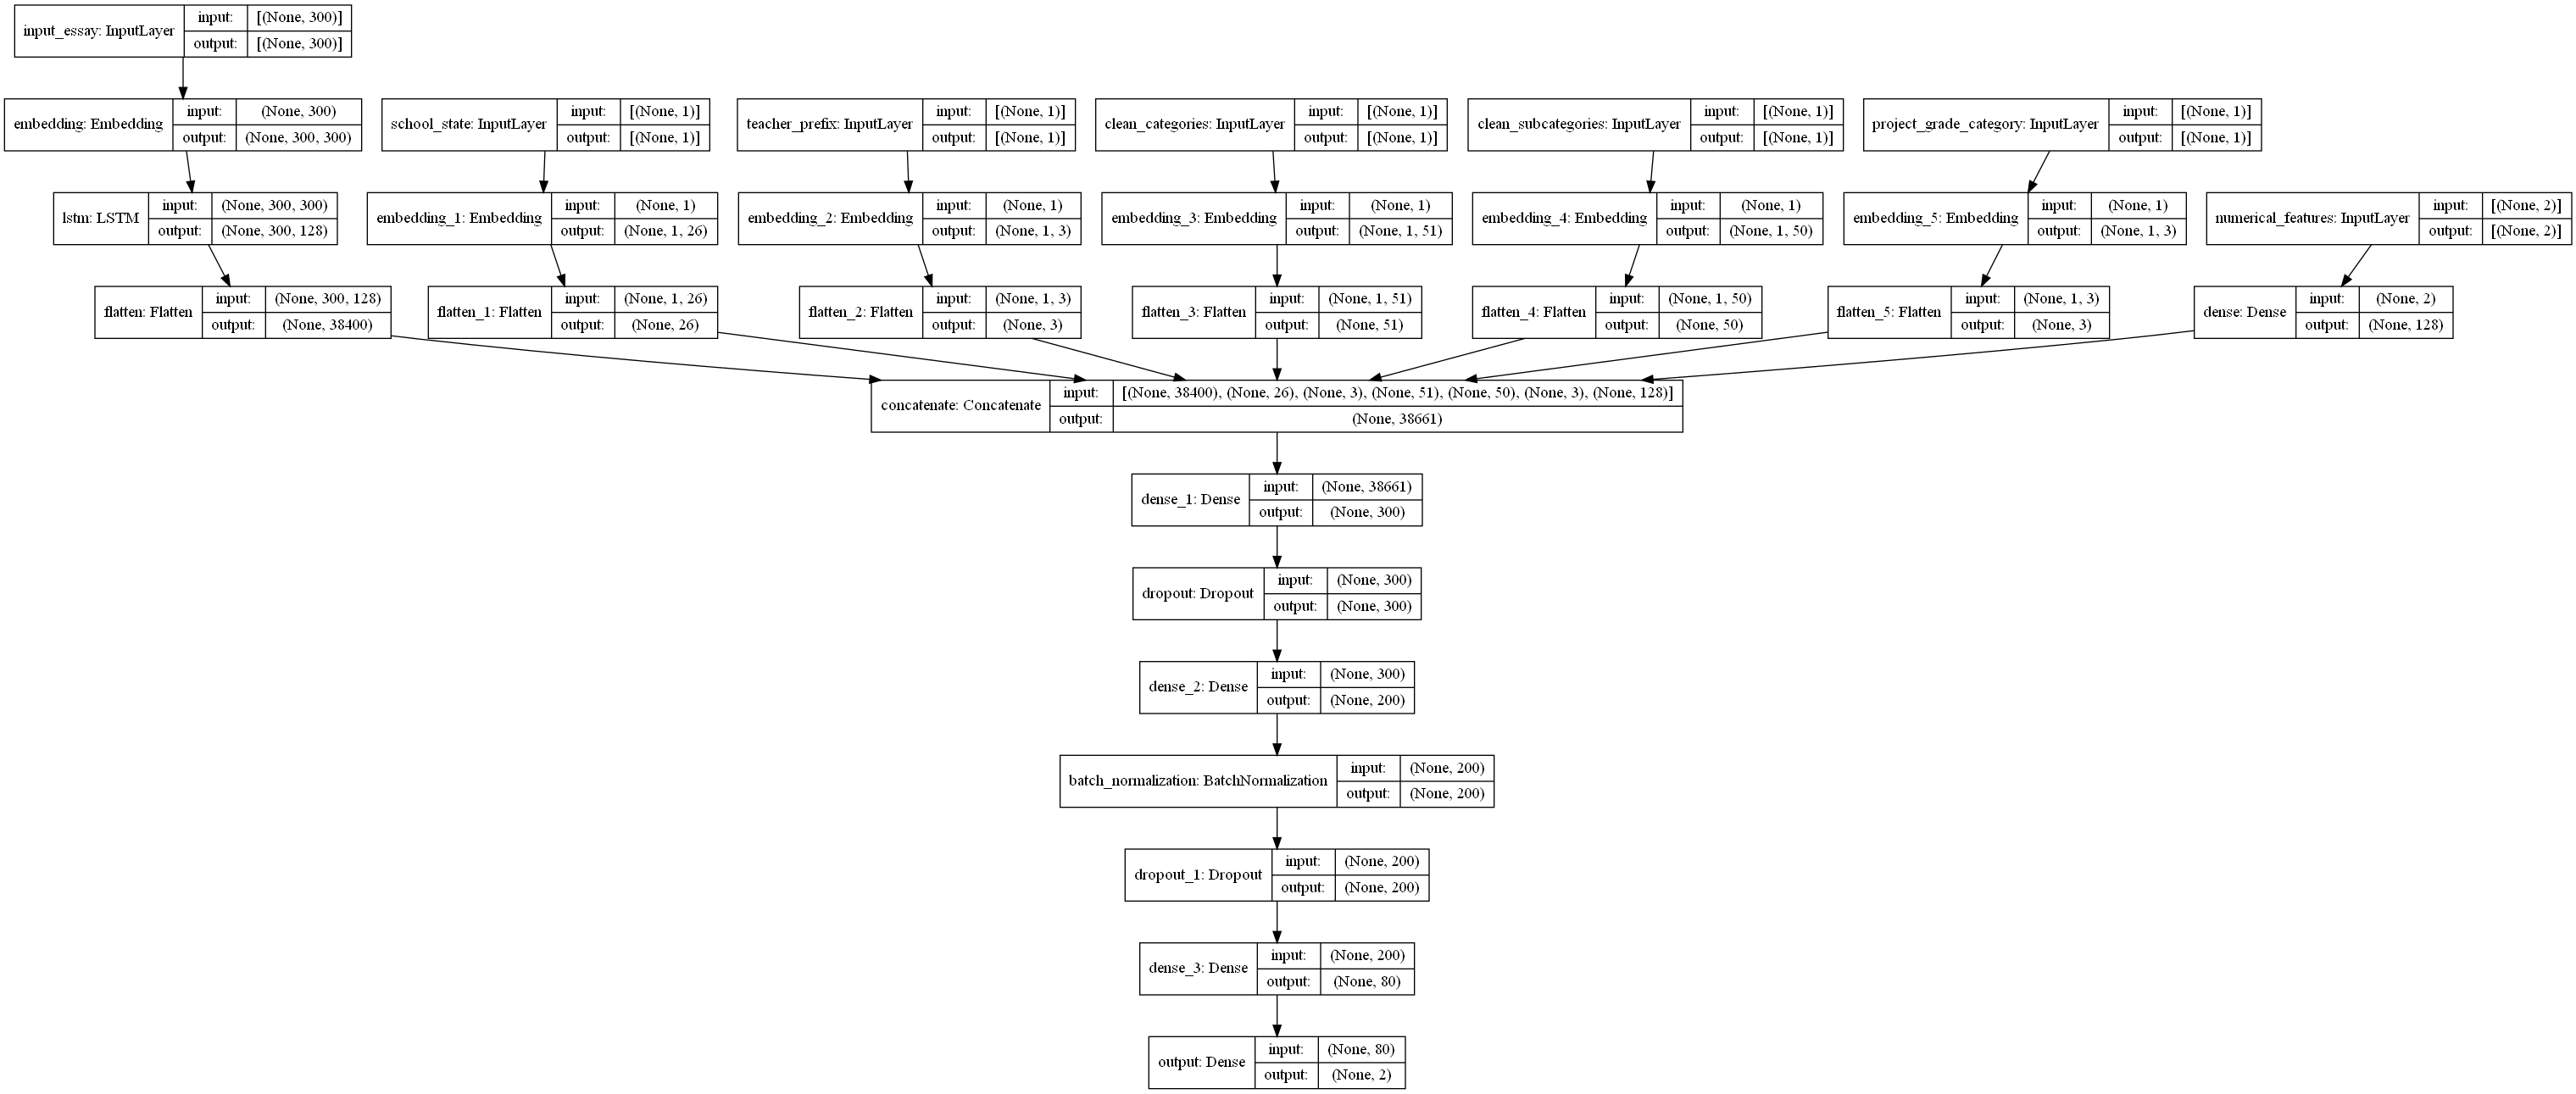

In [40]:
#ref :keras.i/api/util/plot_model
tf.keras.utils.plot_model(Model_1, to_file='model1_lstm.png', show_shapes=True)

#### Model -1 tensorboard

<a href="https://imgur.com/ZNW8mcz"><img src="https://i.imgur.com/ZNW8mcz.png" title="source: imgur.com" /></a>

In [41]:
tf.keras.backend.clear_session()

In [42]:
keras.backend.clear_session()

## Model 2

## Using the tfidf

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

Text(0, 0.5, 'IDF scores')

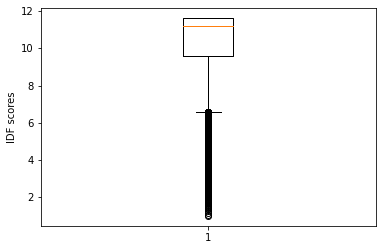

In [44]:
#we'll now get the idf values for our words using the tfidf vectorizer
vectorizer_tfidf = TfidfVectorizer()
data_tfidf = vectorizer_tfidf.fit_transform(X_train["essay"])


#to get the idf dcores for the vectorized text data & plot a box plot for the relevant top values
plt.boxplot(vectorizer_tfidf.idf_)
plt.ylabel("IDF scores")

here, we can see that there are many scores with low idf values, these could be outliars & we'll remove these further

In [45]:
len(vectorizer_tfidf.get_feature_names()) #the size of individual texts considered as features post vectoriations

50440

In [46]:
#Remove the low idf values and high idf values words from our data.

low_val = np.percentile(vectorizer_tfidf.idf_, 10)
high_val = np.percentile(vectorizer_tfidf.idf_, 90)

print(f" high val: {high_val}\n low val:  {low_val}")

 high val: 11.62055875771544
 low val:  7.568773809912135


In [47]:
##we'll select ony the values in the range low to high

data_idf = zip(vectorizer_tfidf.get_feature_names(), vectorizer_tfidf.idf_)
idf_words = [x for x,y in data_idf if (low_val < y < high_val)]
len(idf_words)

25708

now we have the 25708 words that are in the low-high range for the idf scores. we've eleminated out of our range words

In [48]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(idf_words) #tokenization for the idf words set
    
X_train_tokenized_idf = tokenizer.texts_to_sequences(X_train['essay'].values) #here we're tokenizing the essays is our dataset
X_test_tokenized_idf  = tokenizer.texts_to_sequences(X_test['essay'].values)

In [49]:
token_sizelist2 = [len(i) for i in X_train_tokenized_idf]
token_size_2 = max(token_sizelist2)
token_size_2

79

In [50]:
#padding the data vectors, for shape consistency 
X_train_padded_idf = tf.keras.preprocessing.sequence.pad_sequences(X_train_tokenized_idf, maxlen =100 , padding='post' )
X_test_padded_idf  = tf.keras.preprocessing.sequence.pad_sequences(X_test_tokenized_idf, maxlen =100 , padding='post')

In [51]:
X_train_padded_idf.shape

(81936, 100)

In [53]:
##https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory


print('Indexing word vectors_____')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

words=tokenizer.word_index
word_ind2=len(words)+1

#getting the embeddings from the 
word_in_matrix2=np.zeros((word_ind2,100))
for key,value in words.items():
    emb=embeddings_index.get(key)
    if emb is not None:
        word_in_matrix2[value]=emb

Indexing word vectors_____
Found 400000 word vectors.


In [54]:
word_in_matrix2.shape

(25709, 100)

In [55]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import Dense, Input , Dropout
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization

In [57]:
essay_input_idf = Input(shape=(100,), name='input_essay_idf')
#embedding layers for essays top tfidf score words
essay_embedding = Embedding(input_dim=word_ind2, output_dim=100,weights=[word_in_matrix2],trainable=False)(essay_input_idf)
lstm_essay = LSTM(128,return_sequences=True)(essay_embedding)
flatten_1 = Flatten()(lstm_essay)


school_state = Input(shape=(1,), name='school_state')
school_state_embedding = Embedding(input_dim=no_of_unique_states,output_dim=emb_state,input_length=1)(school_state)
flatten_2 = Flatten()(school_state_embedding)

teacher_prefix = Input(shape=(1,), name='teacher_prefix')
teacher_prefix_embedding = Embedding(input_dim=no_of_teacher_prefix,
                                     output_dim=emb_teacher_prefix ,input_length=1)(teacher_prefix)
flatten_3 = Flatten()(teacher_prefix_embedding)



categories = Input(shape=(1,), name='clean_categories')
categories_embedding = Embedding(input_dim=no_of_clean_categories+1,output_dim=no_of_clean_categories,input_length=1)(categories)
flatten_4 = Flatten()(categories_embedding)


subcategories = Input(shape=(1,), name='clean_subcategories')
subcategories_embedding = Embedding(input_dim=no_of_clean_subcategories+1,
                                    output_dim=emb_project_clean_subcategories,input_length=1)(subcategories)
flatten_5 = Flatten()(subcategories_embedding)


project_grade_category = Input(shape=(1,), name='project_grade_category')
project_grade_category_embedding = Embedding(input_dim=no_of_project_grade_category,
                                             output_dim=emb_project_grade_category,input_length=1)(project_grade_category)
flatten_6 = Flatten()(project_grade_category_embedding)


num_features = Input(shape=(2,) , name="numerical_features")
num_dense = Dense(128, activation='relu' , kernel_initializer='he_normal')(num_features)

#Combining all the layers together into one
M1_concat = concatenate([flatten_1 ,flatten_2 , flatten_3 ,flatten_4 , flatten_5 , flatten_6 , num_dense])


M = Dense(300, activation="relu", kernel_initializer="he_normal")(M1_concat)
M = Dropout(0.5)(M)

M = Dense(200,activation="relu",kernel_initializer="glorot_normal")(M)
M = BatchNormalization()(M)
M = Dropout(0.5)(M)
M = Dense(80,activation="sigmoid", kernel_initializer="glorot_normal")(M)

output = Dense(2, activation='softmax', name='output')(M)


Model_2 = Model(inputs=[essay_input_idf, school_state ,teacher_prefix,categories,
                       subcategories ,project_grade_category ,num_features ],outputs=[output])


print(Model_2.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay_idf (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     2570900     input_essay_idf[0][0]            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

In [58]:
#combined list for the train data
train_data_M2 = [X_train_padded_idf,
                 X_train_school_state,
                 X_train_teacher_prefix,
                 X_train_project_clean_categories,
                 X_train_project_clean_subcategories,
                 X_train_project_grade_category,
                 X_train_numeric_features]


#combined list for the validation data
test_data_M2 = [ X_test_padded_idf,
                 X_test_school_state,
                 X_test_teacher_prefix,
                 X_test_project_clean_categories,
                 X_test_project_clean_subcategories,
                 X_test_project_grade_category,
                 X_test_numeric_features]

In [104]:
import datetime

In [59]:
#Callbacks that we're using
#to store our model at each checkpoint
filepath="./tmp/checkpointLSTM"
checkpoint_M1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=0,
                                                   save_best_only=True, mode='max')
earlystop_M2=tf.keras.callbacks.EarlyStopping( monitor='val_auc', min_delta=0, patience=10, verbose=0,
                                            mode='auto', baseline=None, restore_best_weights=False)

nanvalue=tf.keras.callbacks.TerminateOnNaN() #termination on NaN values
log_dir2 = "lstm/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #saving the logs in local
tensorboard_callback_M2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2)

callbacks_M2 = [earlystop_M2,nanvalue,tensorboard_callback_M2]

In [61]:
Model_2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [62]:
Model_2.fit(train_data_M2, y_train_cat, epochs=10,callbacks=callbacks_M2, verbose=1,validation_data=(test_data_M2, y_test_cat))


Epoch 1/10
2561/2561 [==============================] - 59s 22ms/step - loss: 0.4324 - auc: 0.8553 - val_loss: 0.4252 - val_auc: 0.8503
Epoch 2/10
2561/2561 [==============================] - 52s 20ms/step - loss: 0.4291 - auc: 0.8501 - val_loss: 0.4278 - val_auc: 0.8496
Epoch 3/10
2561/2561 [==============================] - 52s 20ms/step - loss: 0.4267 - auc: 0.8494 - val_loss: 0.4257 - val_auc: 0.8494
Epoch 4/10
2561/2561 [==============================] - 53s 21ms/step - loss: 0.4255 - auc: 0.8495 - val_loss: 0.4253 - val_auc: 0.8497
Epoch 5/10
2561/2561 [==============================] - 50s 20ms/step - loss: 0.4249 - auc: 0.8500 - val_loss: 0.4180 - val_auc: 0.8529
Epoch 6/10
2561/2561 [==============================] - 55s 22ms/step - loss: 0.4182 - auc: 0.8546 - val_loss: 0.4174 - val_auc: 0.8579auc: 0.
Epoch 7/10
2561/2561 [==============================] - 53s 21ms/step - loss: 0.4156 - auc: 0.8591 - val_loss: 0.4105 - val_auc: 0.8621
Epoch 8/10
2561/2561 [===================

#### Model -2 

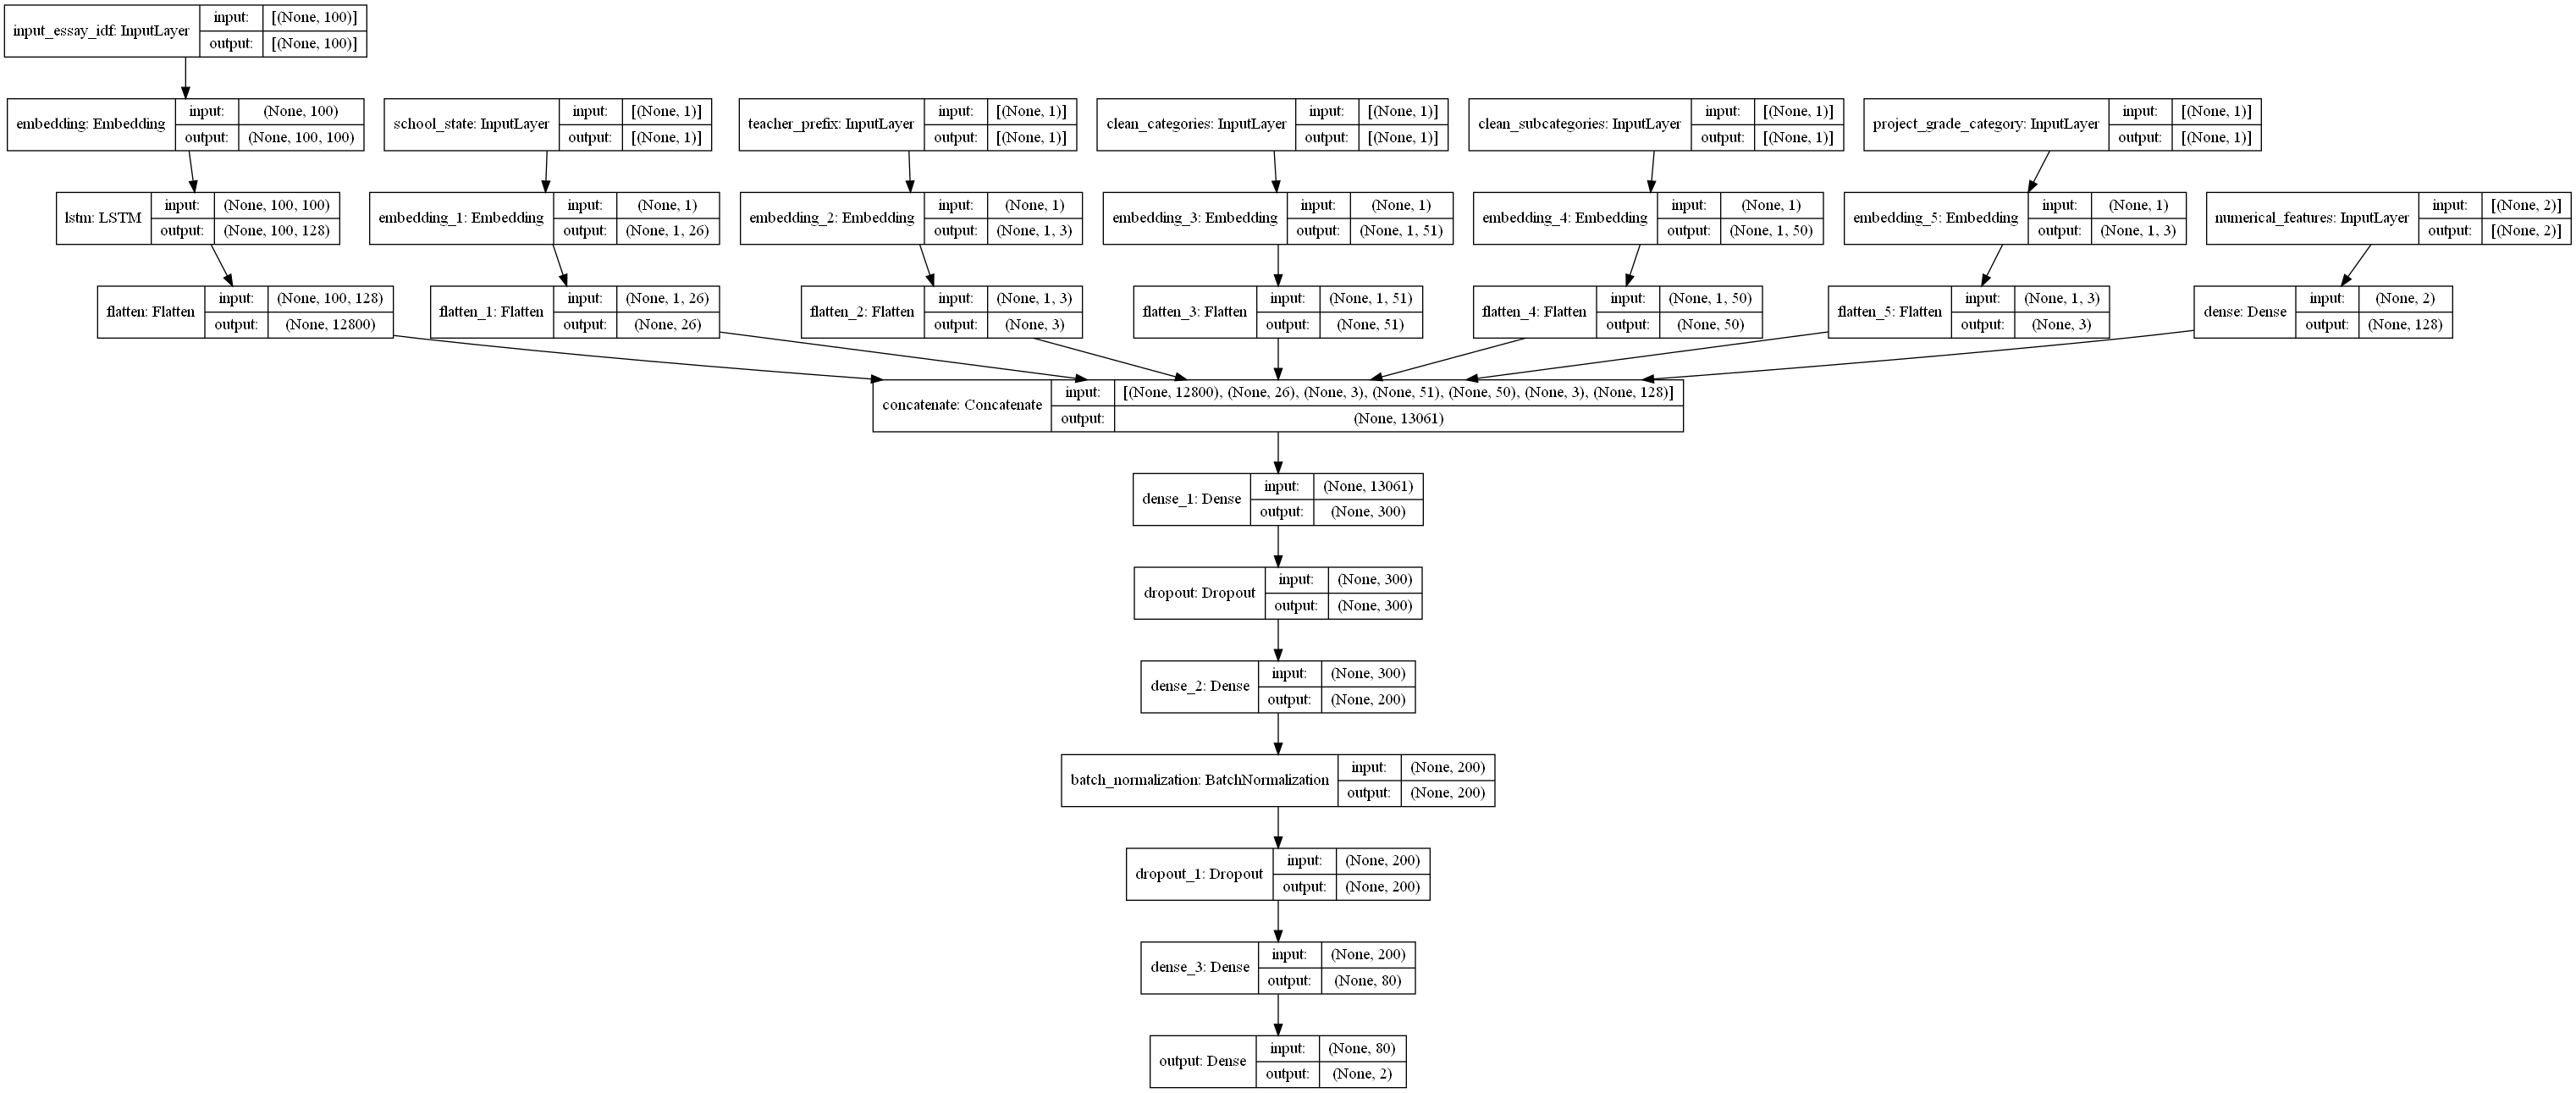

In [63]:
#ref :keras.i/api/util/plot_model
tf.keras.utils.plot_model(Model_2, to_file='model2_lstm.png', show_shapes=True)

#### Model -2 tensorboard

<a href="https://imgur.com/8SX1q8H"><img src="https://i.imgur.com/8SX1q8H.png" title="source: imgur.com" /></a>

In [114]:
tf.keras.backend.clear_session()
keras.backend.clear_session()

## Model 3

In [64]:
#encoding code-ref. Donors Choose ML assignments

<h3> encoding categorical features: School State</h3>

In [65]:
vectorizer = CountVectorizer(binary= True)
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
#ohe here means one hot encoded features

X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

#the distict feature names in the given feature
features_school_state = vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_state_ohe.shape)
print(X_test_state_ohe.shape)
print(features_school_state)
print("="*100)

After vectorizations
(81936, 51)
(27312, 51)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3> encoding categorical features: teacher_prefix</h3>

In [66]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

#the distict feature names in the given feature
features_teacher_prefix = vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_teacher_ohe.shape)
print(X_test_teacher_ohe.shape)
print(features_teacher_prefix)
print("="*100)

After vectorizations
(81936, 5)
(27312, 5)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3> encoding categorical features: project_grade_category</h3>

In [67]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

features_project_grade_category = vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_project_grade_category_ohe.shape)
print(X_test_project_grade_category_ohe.shape)
print(features_project_grade_category)
print("="*100)

After vectorizations
(81936, 4)
(27312, 4)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3> Encoding categorical features: categories</h3>

In [68]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

features_categories = vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_clean_categories_ohe.shape)
print(X_test_clean_categories_ohe.shape)
print(features_categories)
print("="*100)

After vectorizations
(81936, 9)
(27312, 9)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h3> encoding categorical features: sub-categories </h3>

In [69]:
vectorizer = CountVectorizer(binary = True)
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

features_sub_categories = vectorizer.get_feature_names()

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape)
print(X_test_clean_subcategories_ohe.shape)
print(features_sub_categories)
print("="*100)

After vectorizations
(81936, 30)
(27312, 30)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [70]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#Standardizing the teachers previously posted projects
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_projects=scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_projects=scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print("Standardized previously posted projects by a teacher")
print(X_train_projects.shape)
print(X_test_projects.shape)

#Standardizing the price
scaler.fit(X_train['price'].values.reshape(-1,1))

X_train_price = scaler.transform(X_train['price'].values.reshape(-1,1))
X_test_price = scaler.transform(X_test['price'].values.reshape(-1,1))
print("\nStandardized prize matrix-shapes")
print(X_train_price.shape)
print(X_test_price.shape)

Standardized previously posted projects by a teacher
(81936, 1)
(27312, 1)

Standardized prize matrix-shapes
(81936, 1)
(27312, 1)


In [71]:
from scipy.sparse import hstack

In [72]:
#stacking all the non-text layers together
X_train_nontext = hstack((X_train_state_ohe,X_train_teacher_ohe,X_train_project_grade_category_ohe,
                          X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_projects,X_train_price)).todense()



X_test_nontext = hstack((X_test_state_ohe,X_test_teacher_ohe,X_test_project_grade_category_ohe,
                          X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_projects,X_test_price)).todense()



print(f"Non-text train data: {X_train_nontext.shape} \nNon-text train data :{X_test_nontext.shape}")
print("="*100)

Non-text train data: (81936, 101) 
Non-text train data :(27312, 101)


In [73]:
##https://stackoverflow.com/questions/45774369/convert-2d-tensor-to-3d-in-tensorflow

X_train_nontext = np.expand_dims(X_train_nontext,2)
X_test_nontext = np.expand_dims(X_test_nontext,2)

In [74]:
print(f"Non-text train data tensor: {X_train_nontext.shape} \nNon-text train data tensor :{X_test_nontext.shape}")
print("="*100)

Non-text train data tensor: (81936, 101, 1) 
Non-text train data tensor :(27312, 101, 1)


In [77]:
essay_input_idf = Input(shape=(100,), name='input_essay_idf')

essay_embedding = Embedding(input_dim=word_ind1, output_dim=300,weights=[word_in_matrix1],trainable=False)(essay_input_idf)
lstm_essay = LSTM(128,return_sequences=True)(essay_embedding)
flatten_1 = Flatten()(lstm_essay)


input_nontext  = Input(shape=(101,1), name='input_nontext')

#adding convolution layers
Conv1 = Conv1D(filters=128 , kernel_size=3,activation='relu' ,padding='same')(input_nontext)
Conv2 = Conv1D(filters=64, kernel_size=3,activation='relu' , padding='same')(Conv1)

flatten_nontext = Flatten()(Conv2)


#Combining all the layers(text & non-text) together into one
M1_concat = concatenate([flatten_1,flatten_nontext])


M = Dense(300, activation="relu", kernel_initializer="he_normal")(M1_concat)
M = Dropout(0.5)(M)

M = Dense(200,activation="relu",kernel_initializer="glorot_normal")(M)
M = BatchNormalization()(M)
M = Dropout(0.5)(M)
M = Dense(80,activation="sigmoid", kernel_initializer="glorot_normal")(M)

output = Dense(2, activation='softmax', name='output')(M)

Model_3 = Model(inputs=[essay_input_idf,input_nontext],outputs=[output])

print(Model_3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay_idf (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_nontext (InputLayer)      [(None, 101, 1)]     0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 300)     15143100    input_essay_idf[0][0]            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 101, 128)     512         input_nontext[0][0]              
____________________________________________________________________________________________

In [78]:
#the inut data as tetx & non-text
train_data_M3 =  [X_train_padded_idf,X_train_nontext]
test_data_M3 = [X_test_padded_idf,X_test_nontext]

In [79]:
import datetime

In [80]:
#Callbacks that we're using
#to store our model at each checkpoint
filepath="./tmp/checkpointLSTM"
checkpoint_M3 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_auc',  verbose=0,
                                                   save_best_only=True, mode='max')
earlystop_M3=tf.keras.callbacks.EarlyStopping( monitor='val_auc', min_delta=0, patience=10, verbose=1,
                                            mode='auto', baseline=None, restore_best_weights=False)

nanvalue=tf.keras.callbacks.TerminateOnNaN() #termination on NaN values
log_dir3 = "lstm/fit3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #saving the logs in local
tensorboard_callback_M3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3)

callbacks_M3 = [earlystop_M3,nanvalue,tensorboard_callback_M3] #callbacks list used 

In [82]:
Model_3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [83]:
Model_3.fit(train_data_M3, y_train_cat, epochs=10,callbacks=callbacks_M3, verbose=1,validation_data=(test_data_M3, y_test_cat))


Epoch 1/10
2561/2561 [==============================] - 57s 19ms/step - loss: 0.4391 - auc_1: 0.8404 - val_loss: 0.4149 - val_auc_1: 0.8640
Epoch 2/10
2561/2561 [==============================] - 44s 17ms/step - loss: 0.4165 - auc_1: 0.8674 - val_loss: 0.4155 - val_auc_1: 0.8704 - loss: 0.4165 - a
Epoch 3/10
2561/2561 [==============================] - 44s 17ms/step - loss: 0.4133 - auc_1: 0.8717 - val_loss: 0.4163 - val_auc_1: 0.8735
Epoch 4/10
2561/2561 [==============================] - 44s 17ms/step - loss: 0.4120 - auc_1: 0.8744 - val_loss: 0.4165 - val_auc_1: 0.8752
Epoch 5/10
2561/2561 [==============================] - 45s 17ms/step - loss: 0.4079 - auc_1: 0.8759 - val_loss: 0.4160 - val_auc_1: 0.8771
Epoch 6/10
2561/2561 [==============================] - 45s 18ms/step - loss: 0.3956 - auc_1: 0.8780 - val_loss: 0.4199 - val_auc_1: 0.8797
Epoch 7/10
2561/2561 [==============================] - 46s 18ms/step - loss: 0.3844 - auc_1: 0.8807 - val_loss: 0.4423 - val_auc_1: 0.8827
E

#### Model-3 Plot

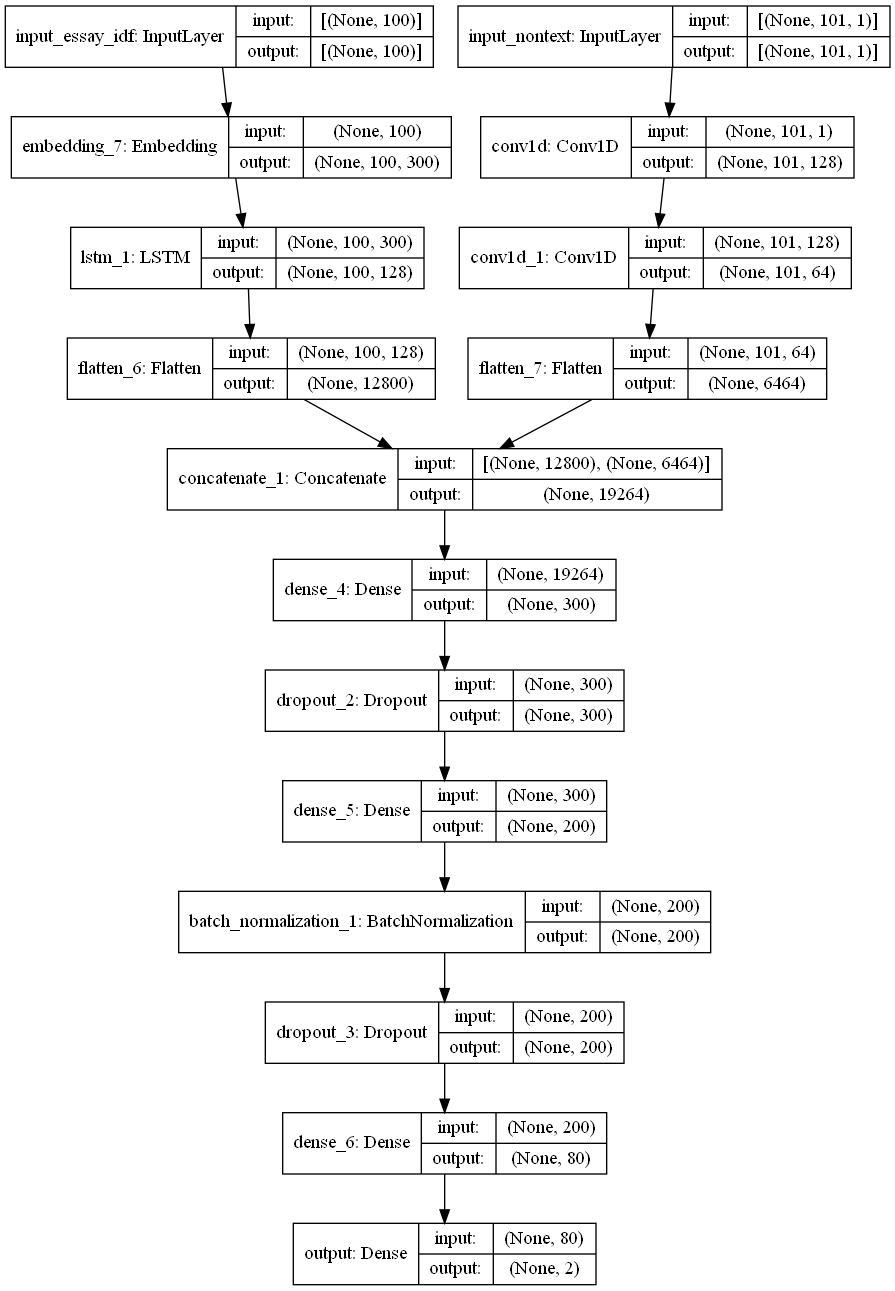

In [84]:
#ref :keras.i/api/util/plot_model
tf.keras.utils.plot_model(Model_3, to_file='model3_lstm.png', show_shapes=True)

#### Model -3 tensorboard

<a href="https://imgur.com/DtDahtX"><img src="https://i.imgur.com/DtDahtX.png" title="source: imgur.com" /></a>

In [89]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

model_summarize = PrettyTable()
model_summarize.field_names = [ "Model" ,"auc", "val_auc"]
model_summarize.add_row(["Model 1 - Embedding essays","0.9036" ,"0.9043" ])
model_summarize.add_row(["Model 2 - tfidf top score words", "0.9043" , "0.8703"])
model_summarize.add_row(["Model 3 - Seq text & non-text", "0.8895", "0.8921"])


print(model_summarize)

+---------------------------------+--------+---------+
|              Model              |  auc   | val_auc |
+---------------------------------+--------+---------+
|    Model 1 - Embedding essays   | 0.9036 |  0.9043 |
| Model 2 - tfidf top score words | 0.9043 |  0.8703 |
|  Model 3 - Seq text & non-text  | 0.8895 |  0.8921 |
+---------------------------------+--------+---------+


### Summary

- For our text data we have tokenized & padded our data to be used as input in our models
- In second model we've neglected the words with low tfidf scores
- In the third model we are providng separately the text & non text features
- The main aspect in our implementation is understanding & applying the proper featurizations

- Using LSTM here provides us with better performance than the ML models used previously

Ref : AAIC ref notebooks